# Bringing the storage data into NUTS 3

In [8]:
%reset -f
import json
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from disaggregator import config, data, spatial, plot

## Load the NUTS 3 geometry of Germany

In [9]:
nuts = data.database_shapes()

## Load the storages from Germany that are taken from the gisGRID_gas database

Transform the GPS (EPSG:4326) coordinates into EPSG:25832 that are what the NUTS system uses

In [10]:
with open("project_data/in/germanStorages.json", 'r', encoding = 'utf-8') as file:
    sto = json.load(file)

points = []
for s in sto:
    points.append(Point(s["geometry"]["coordinates"][0], s["geometry"]["coordinates"][1]))

storages = gpd.GeoDataFrame(geometry = points, crs = "EPSG:4326")
storages = storages.to_crs("EPSG:25832")

## Bring more data to the transformed data

In [11]:
storages["nuts"] = [sto[i]["properties"]["param"]["nuts_id_3"] for i in range(len(sto))]

storages["pipe2sto"] = [sto[i]["properties"]["param"]["max_cap_pipe2store_M_m3_per_d"] for i in range(len(sto))]
storages["sto2pipe"] = [sto[i]["properties"]["param"]["max_cap_store2pipe_M_m3_per_d"] for i in range(len(sto))]

storages["max_cap"] = [sto[i]["properties"]["param"]["max_cushionGas_M_m3"] for i in range(len(sto))]

storages["max_pre"] = [sto[i]["properties"]["param"]["max_storage_pressure_bar"] for i in range(len(sto))]
storages["min_pre"] = [sto[i]["properties"]["param"]["min_storage_pressure_bar"] for i in range(len(sto))]

storages

,geometry,nuts,pipe2sto,sto2pipe,max_cap,max_pre,min_pre
0,POINT (618892.702 5675621.409),DEG09,2.234552,1.451600,236.000000,36.00,8.200945
1,POINT (696623.255 5700075.096),DEE0B,47.234845,32.278684,121.000000,150.00,15.000000
2,POINT (786627.872 5826520.301),DE300,2.815225,5.269749,305.000000,128.00,60.000000
3,POINT (690456.911 5736863.799),DEE0C,12.672000,36.720000,116.000000,100.00,10.000000
4,POINT (754456.652 5335444.409),DE21M,23.647889,30.738737,1157.000000,161.00,52.000000
...,...,...,...,...,...,...,...
66,POINT (678709.095 5513836.828),DE246,7.266799,9.524319,413.386555,120.25,57.470588
67,POINT (370347.342 5832833.096),DE949,7.266799,9.524319,413.386555,120.25,57.470588
68,POINT (578965.304 5802371.081),DE91A,7.266799,9.524319,413.386555,120.25,57.470588
69,POINT (614257.622 5895524.508),DE935,7.266799,9.524319,413.386555,120.25,57.470588


<AxesSubplot:>

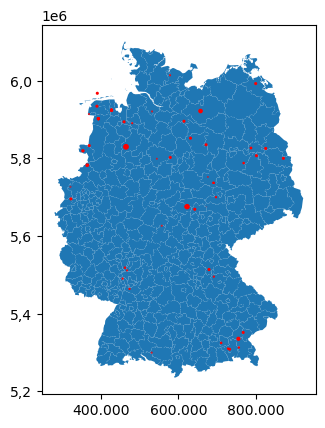

In [12]:
fig, ax = plt.subplots()
nuts.plot(ax = ax) # Plot Germany
storages.plot(ax = ax, color = 'red', markersize = 10 * storages["max_cap"] / storages["max_cap"].max()) # Plot the storages

## Save the data with the important data from the original file

In [13]:
with open("project_data/out/storages.json", 'w') as file:
    json.dump(storages.to_json(), file, indent = 4)

## Bringing the pipes data

In [14]:
%reset -f
import json
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import LineString
from disaggregator import config, data, spatial, plot

In [15]:
import pandas as pd
pd.options.mode.chained_assignment = None  # None for no warning, 'warn' for a warning, and 'raise' for an error

In [16]:
nuts = data.database_shapes()

## Import the pipes

In [17]:
with open("project_data/in/germanPipes.json", 'r', encoding = 'utf-8') as file:
    pipes = json.load(file)

pPlots = []

for p in pipes:
    pPlots.append(LineString( p["geometry"]["coordinates"] ))
pPlots = gpd.GeoDataFrame(geometry = pPlots, crs = "EPSG:4326")
pPlots = pPlots.to_crs("EPSG:25832")

Text(0.5, 1.0, 'Map of Germany with pipes overlayed')

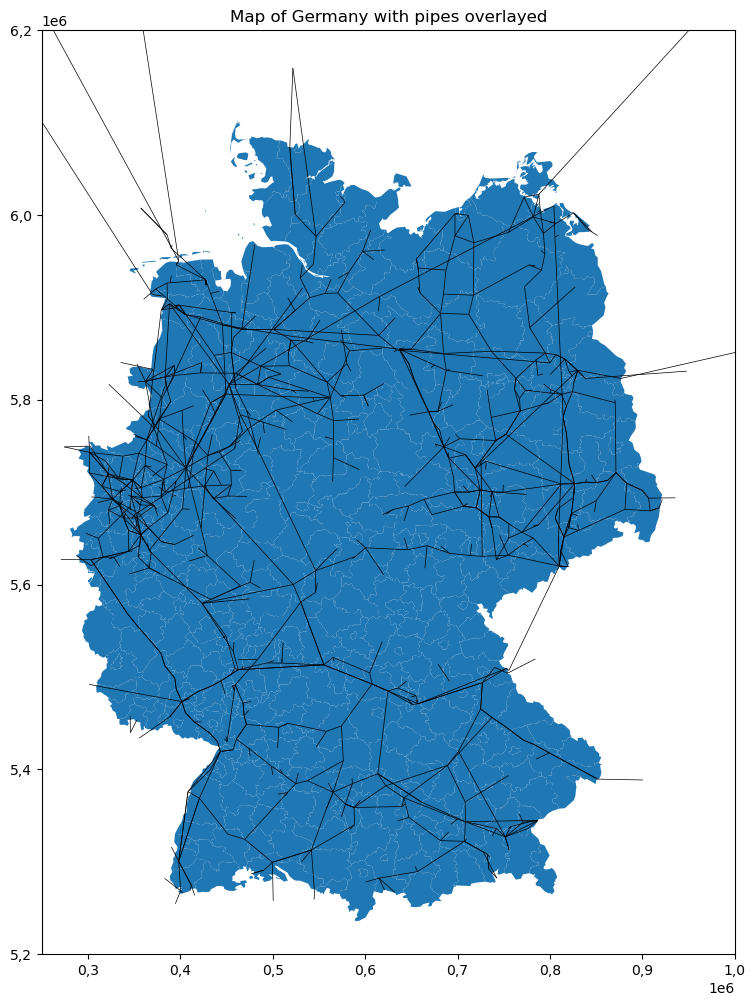

In [18]:
fig, ax = plt.subplots(figsize=(20, 12))
nuts.plot(ax = ax)
pPlots.plot(ax = ax, color = "black", linewidth = 0.5)

ax.set_xlim(250000, 1000000)
ax.set_ylim(5.2e6, 6.2e6)

ax.set_title("Map of Germany with pipes overlayed")

In [19]:
width = [pipes[i]["capacity"] for i in range(len(pipes))]
width = np.array(width)

width = width / width.max() # Normalize the array

<AxesSubplot:title={'center':'Map of Germany with pipes overlayed and thickness proportional to the capacity'}>

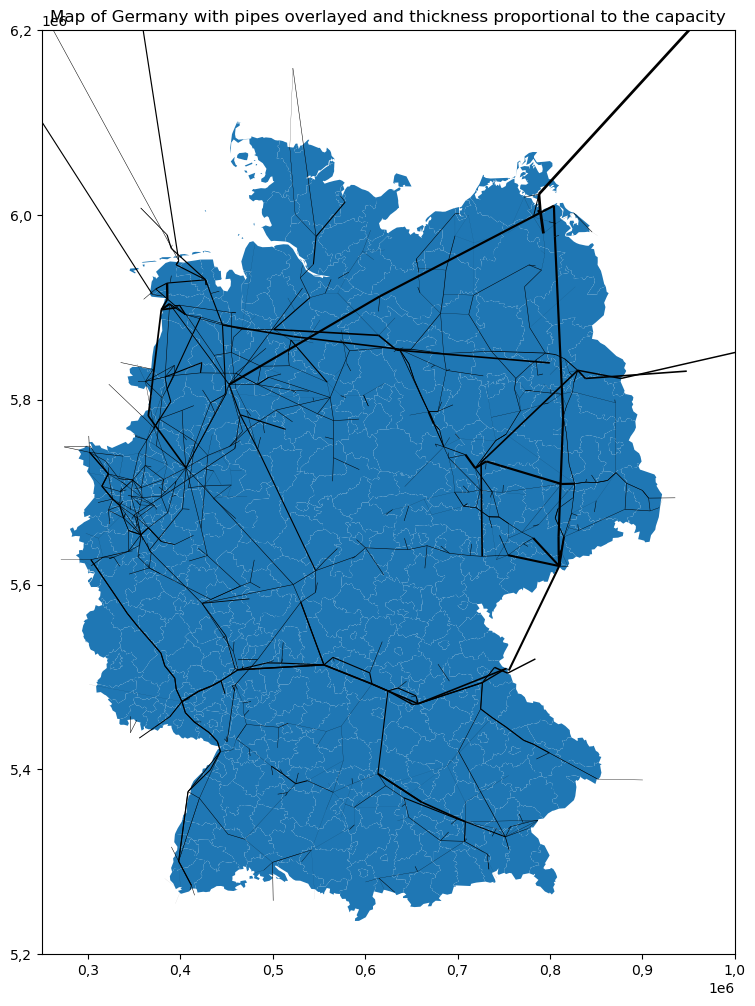

In [20]:
fig, ax = plt.subplots(figsize=(20, 12))
nuts.plot(ax = ax)

ax.set_title("Map of Germany with pipes overlayed and thickness proportional to the capacity")
ax.set_xlim(250000, 1000000)
ax.set_ylim(5.2e6, 6.2e6)

pPlots.plot(ax = ax, color = "black", linewidth = width * 2)

## Showing what parts give more than they take
First, take the districts of Germany and take out the information that is not relevant. Then create two columns to show the volume of gas (in Mm^3 / day) that goes in and out of each district.

In [21]:
pipeLines = nuts.reindex(nuts.index)
pipeLines = pipeLines.drop(columns = ["geometry", "id_ags", "gen", "fl_km2"])

pipeLines["inComing"] = np.zeros(len(pipeLines.index))
pipeLines["outGoing"] = np.zeros(len(pipeLines.index))
pipeLines["goingThr"] = np.zeros(len(pipeLines.index))
pipeLines.head()

,inComing,outGoing,goingThr
nuts3,,,
DE111,0.0,0.0,0.0
DE112,0.0,0.0,0.0
DE113,0.0,0.0,0.0
DE114,0.0,0.0,0.0
DE115,0.0,0.0,0.0


Creating a function to locate the row because pandas apparently can't

In [22]:
indexes = pipeLines.index.tolist()

def getPos(nuts): # Takes the nuts3 code and returns
    if (nuts in indexes): return indexes.index(nuts)
    else: return -1

Cycling through all the pipes and adding the incoming and outcoming volume flows

In [23]:
for p in pipes:
    # First we do the incoming gas
    outG = getPos(p["nuts3"][0])
    if (outG != -1):
        pipeLines["outGoing"][outG] += p["capacity"]
        pipeLines["goingThr"][outG] -= p["capacity"]
    
    inCo = getPos(p["nuts3"][1])
    if (inCo != -1):
        pipeLines["inComing"][inCo] += p["capacity"]
        pipeLines["goingThr"][outG] += p["capacity"]

Plot the three columns to show
* Where most of the gas arrives
* Where most of the gas leaves
* Where most of the gas initially arrives of finally stays

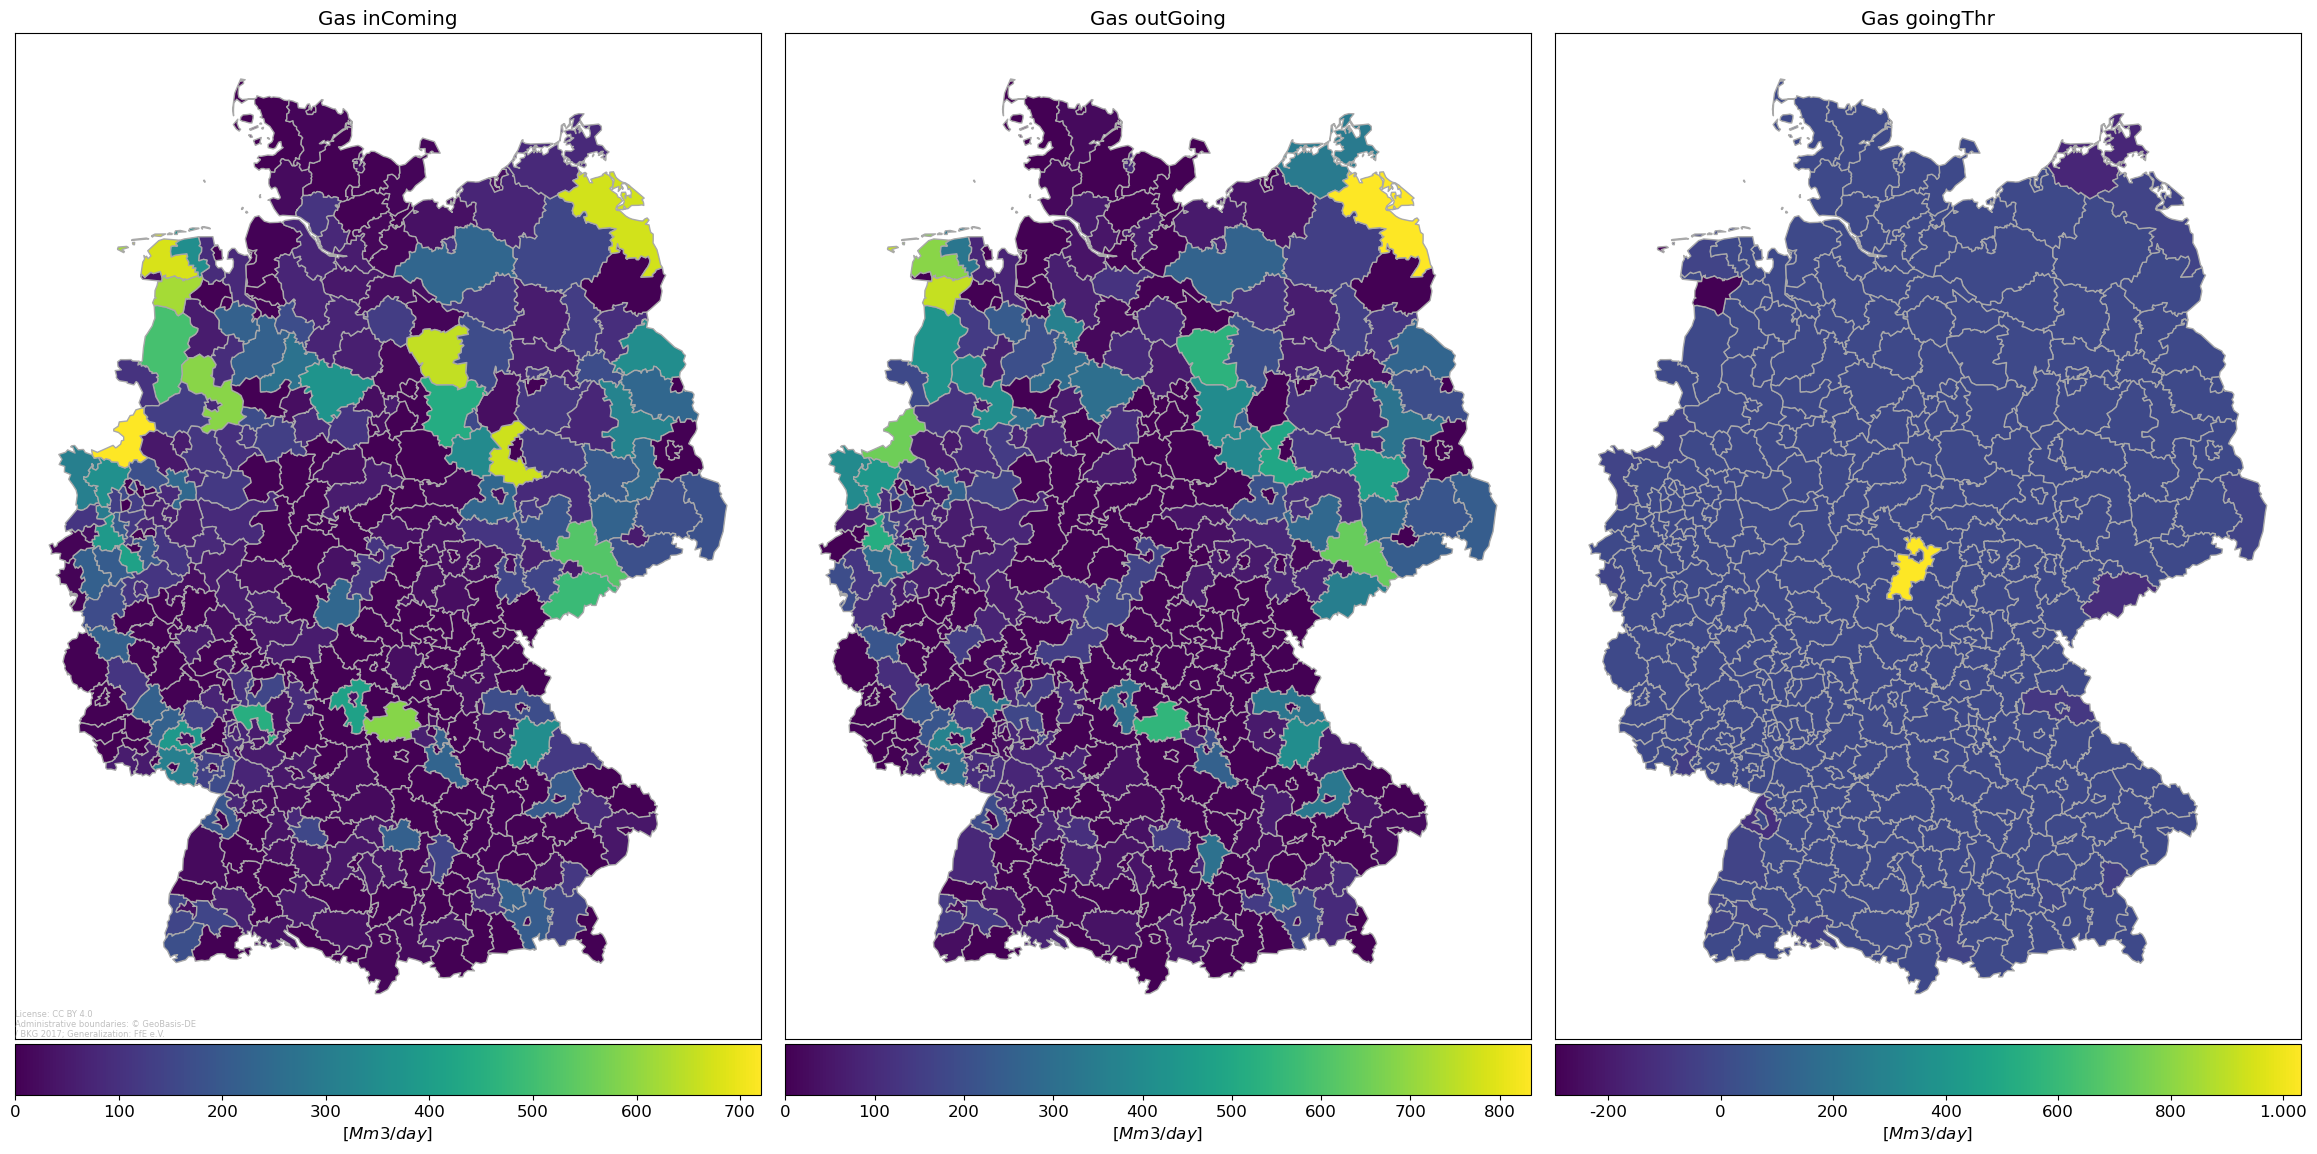

In [24]:
fig, ax = plot.choropleth_map(pipeLines, axtitle = "Gas", unit = ["Mm3/day", "Mm3/day", "Mm3/day"], colorbar_each_subplot = True, relative = False)

# Bringing the industry consumers

In [25]:
%reset -f
import copy
import json
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from disaggregator import config, data, spatial, plot
from shapely.geometry import Point, MultiPolygon, Polygon

In [26]:
files = ["amonia.json", "refineries.json", "steel.json"]

importData = []

for file in files:
    with open("project_data/in/" + file, 'r', encoding = "utf-8") as f:
        importData.append(json.load(f))

toDelete = []
points = []

for dataE in importData:
    temp = []
    for element in dataE:
        if (element["Latitude"] == ""):
            toDelete.append(element)
            continue
        
        element["geometry"] = [float(element["Longitude"]), float(element["Latitude"])]

        del element["Latitude"]
        del element["Longitude"]
        
        temp.append(Point(element["geometry"][0], element["geometry"][1]))
    points.append(temp)

for toD in toDelete: # Delete the industry that doesn't have coordinates
    for dataE in importData:
        if (not toD in dataE): continue
        dataE.remove(toD)

Separate the data into different variables

In [27]:
amonia = copy.deepcopy(importData[0])
refineries = copy.deepcopy(importData[1])
steel = copy.deepcopy(importData[2])

aPoints = gpd.GeoDataFrame(geometry = copy.deepcopy(points[0]), crs = "EPSG:4326")
rPoints = gpd.GeoDataFrame(geometry = copy.deepcopy(points[1]), crs = "EPSG:4326")
sPoints = gpd.GeoDataFrame(geometry = copy.deepcopy(points[2]), crs = "EPSG:4326")

aPoints = aPoints.to_crs("EPSG:25832")
rPoints = rPoints.to_crs("EPSG:25832")
sPoints = sPoints.to_crs("EPSG:25832")

Add the different characteristic to the different points lists

In [28]:
aPoints["production"] = [int(a["Production"]) for a in amonia]
rPoints["production"] = [int(r["Production"]) for r in refineries]
sPoints["production"] = [int(s["Production"]) for s in steel]

Now that all the data has been added, we can plot them

In [29]:
nuts = data.database_shapes()

nuts = nuts.drop(columns = ["id_ags", "gen", "fl_km2"])

Import the localisation data

Text(0.5, 1.0, 'Amonia production sites in Germany')

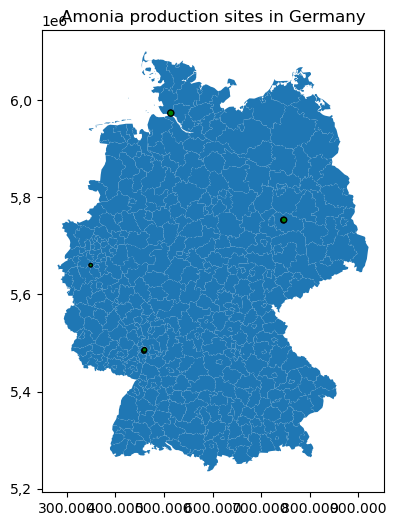

In [30]:
fig, ax = plt.subplots(figsize = (20, 6))
nuts.plot(ax = ax)
aPoints.plot(ax = ax, color = 'green', markersize = 20 * aPoints["production"] / aPoints["production"].max(), edgecolor='black')
ax.set_title("Amonia production sites in Germany")

Text(0.5, 1.0, 'Refineries in Germany')

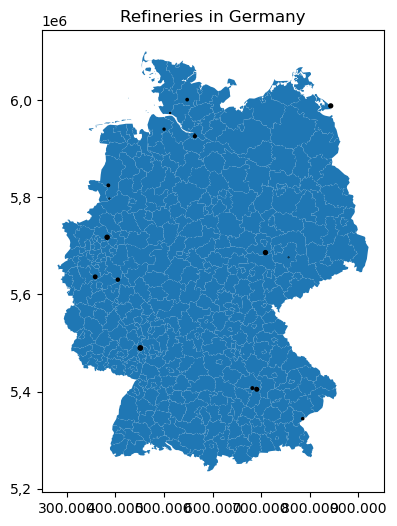

In [31]:
fig, ax = plt.subplots(figsize = (20, 6))
nuts.plot(ax = ax)
rPoints.plot(ax = ax, color = 'black', markersize = 10 * rPoints["production"] / rPoints["production"].max())
ax.set_title("Refineries in Germany")

Text(0.5, 1.0, 'Steel factories in Germany')

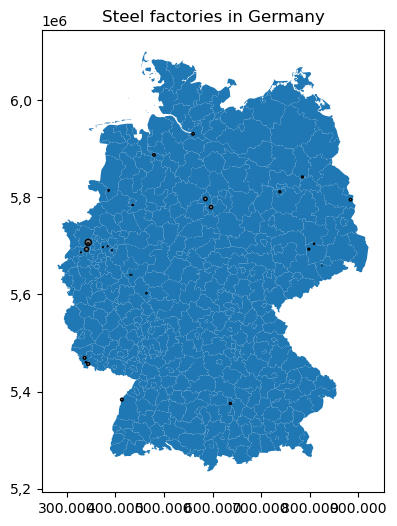

In [32]:
fig, ax = plt.subplots(figsize = (20, 6))
nuts.plot(ax = ax)
sPoints.plot(ax = ax, color = 'grey', markersize = 20 * sPoints["production"] / sPoints["production"].max(), edgecolor='black')
ax.set_title("Steel factories in Germany")

## Now we will find the NUTS 3 district where they are located

In [33]:
aPoints = gpd.sjoin(aPoints, nuts)
rPoints = gpd.sjoin(rPoints, nuts)
sPoints = gpd.sjoin(sPoints, nuts)

In [ ]:
aPoints["consumption"] = [(int(a["Production"]) * 176.14 / 1000) for a in amonia]
rPoints["consumption"] = [(int(r["Production"]) * 1.02 / 227.69) for r in refineries]
sPoints["consumption"] = [(int(s["Production"]) * 0.97 * 54.171367 / 1000)for s in steel]

# Redo of lines -> TO BE MOVED

In [35]:
%reset -f
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import LineString, Point
from disaggregator import config, data, spatial, plot

In [36]:
nuts = data.database_shapes()
nuts = nuts.drop(columns = ["id_ags", "gen", "fl_km2"])

In [37]:
with open("project_data/in/germanPipesMerged.json", 'r', encoding = 'utf-8') as file:
    pipes = json.load(file)

with open("project_data/in/germanPipesRaw.json", 'r', encoding = 'utf-8') as file:
    pipes2 = json.load(file)

In [38]:
coords = []

for p in pipes:
    if (p["geometry"]["coordinates"] in coords): continue
    coords.append(p["geometry"]["coordinates"])

for p in pipes2:
    if (p["geometry"]["coordinates"] in coords): continue
    pipes.append(p)

pPlots = []

for p in pipes:
    pPlots.append(LineString( p["geometry"]["coordinates"] ))
pPlots = gpd.GeoDataFrame(geometry = pPlots, crs = "EPSG:4326")
pPlots = pPlots.to_crs("EPSG:25832")

In [39]:
def get_start_end_points(line):
    return {'Start': line.coords[0], 'End': line.coords[-1]}

# Apply the function to create a new GeoDataFrame with start and end points
points_data = pPlots['geometry'].apply(get_start_end_points).apply(pd.Series)

# Create a new GeoDataFrame with the points
start_Points = gpd.GeoDataFrame(geometry=[Point(x) for x in points_data['Start']], crs="EPSG:25832")
end_Points   = gpd.GeoDataFrame(geometry=[Point(x) for x in points_data['End']], crs="EPSG:25832")

resultStart = gpd.sjoin(start_Points, nuts, how="left").rename(columns={'geometry': 'geomS', 'index_right': 'indexS'})
resultEnd   = gpd.sjoin(end_Points, nuts, how="left").rename(columns={'geometry': 'geomE', 'index_right': 'indexE'})

finalPipes = pd.concat([resultStart, resultEnd], axis=1)
finalPipes = finalPipes.reset_index(drop=True)
finalPipes = finalPipes.drop(columns = ["geomS", "geomE"]).rename(columns = {"indexS": "origin", "indexE": "destination"})

In [40]:
pipesDestination = nuts.copy().drop(columns = ["geometry"])

pipesDestination["comingIn"] = np.zeros(401)
pipesDestination["outGoing"] = np.zeros(401)

for index, p in finalPipes.iterrows(): # Replace those that are double NaN
    if ((type(p["origin"]) != type("") and np.isnan(p["origin"])) and (type(p["destination"]) != type("") and np.isnan(p["destination"]))):
        if (not "nuts_id_3" in pipes[index]["properties"]["param"]): continue # If it doesn't have the option to look for the NUTS3, don't bother
        
        p["origin"] = pipes[index]["properties"]["param"]["nuts_id_3"][0]
        p["destination"] = pipes[index]["properties"]["param"]["nuts_id_3"][1]
    
    if ((type(p["destination"]) != type("") and np.isnan(p["destination"]))):
        if (not "nuts_id_3" in pipes[index]["properties"]["param"] or len(pipes[index]["properties"]["param"]["nuts_id_3"]) == 1): continue
        p["destination"] = pipes[index]["properties"]["param"]["nuts_id_3"][1]

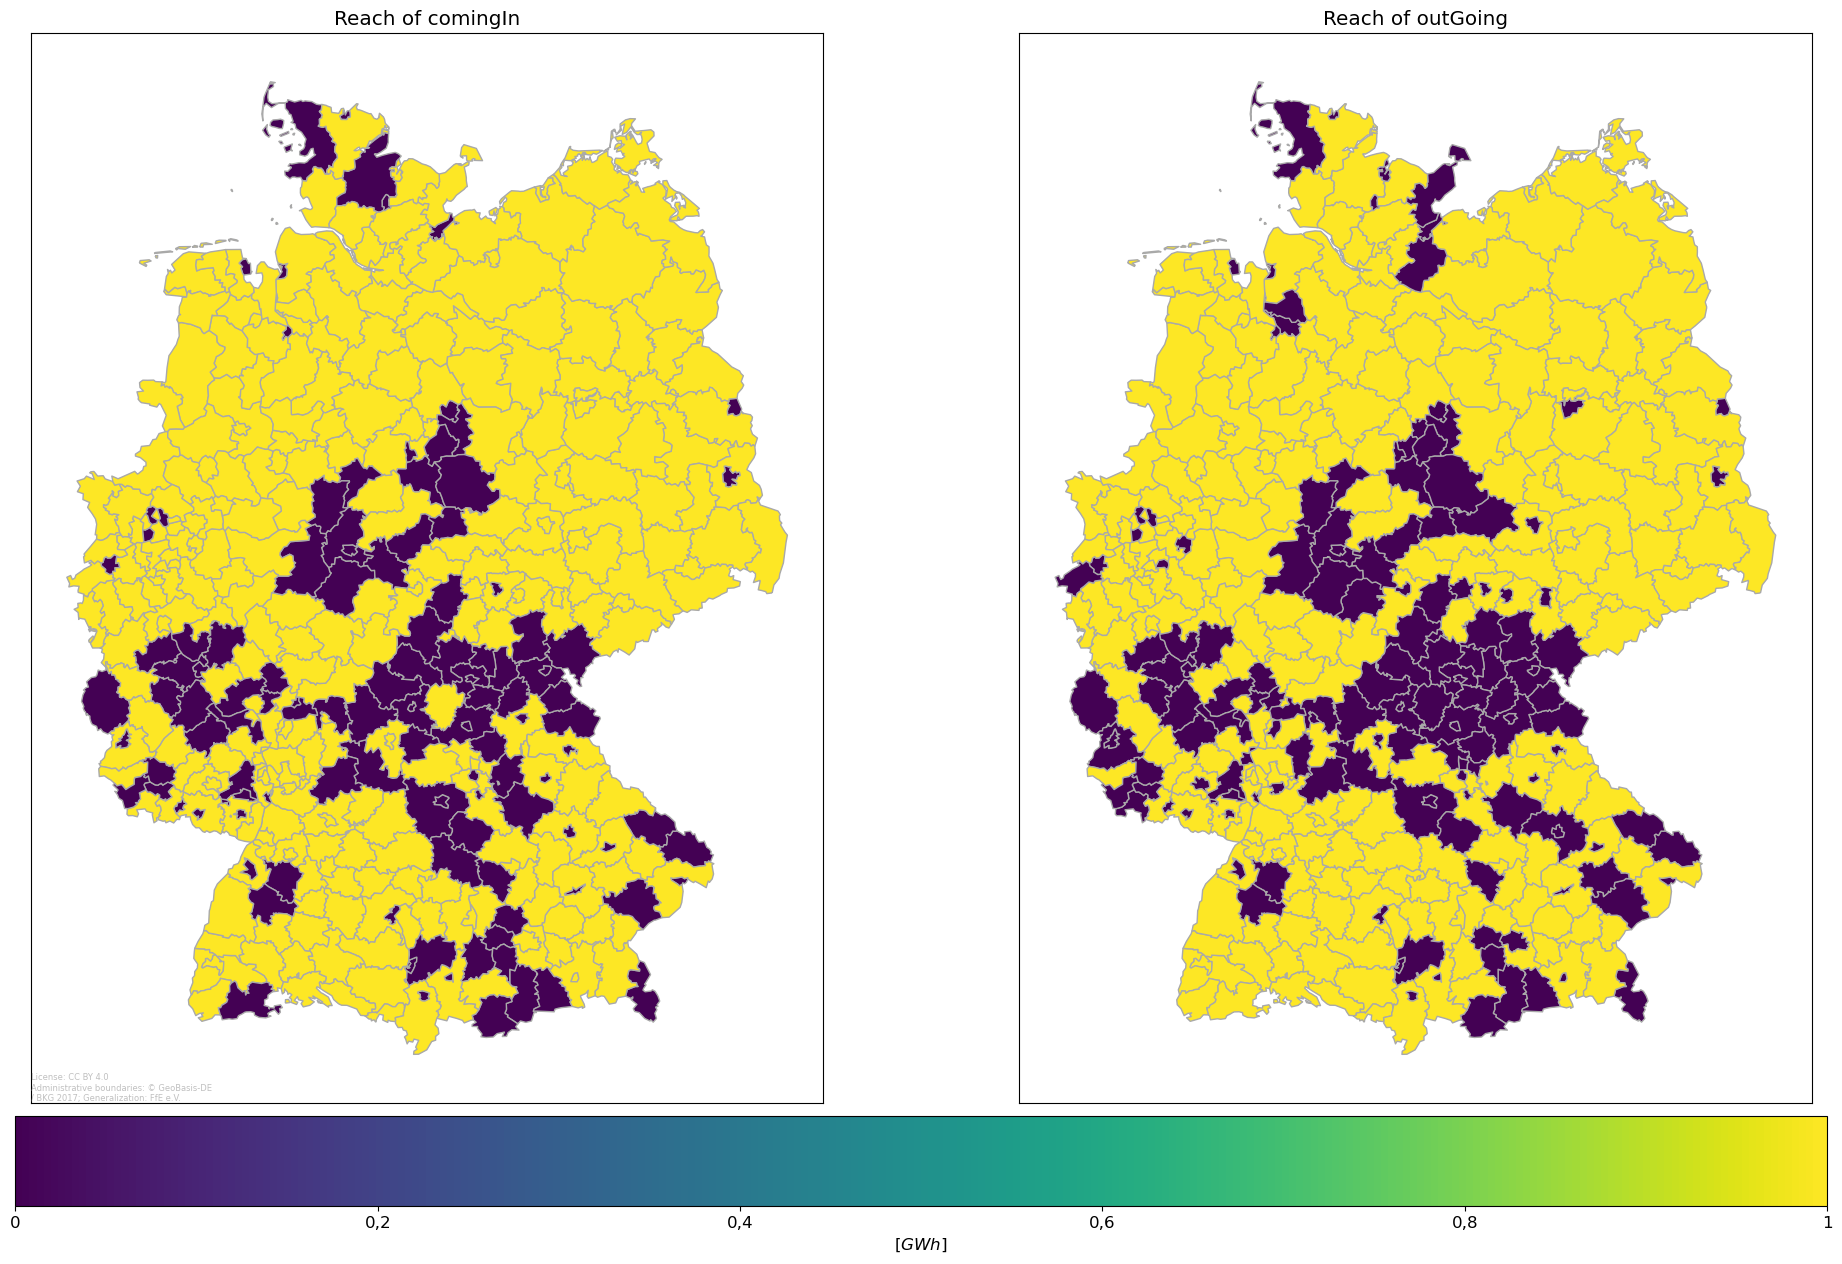

In [41]:
for _, p in finalPipes.iterrows():
    pipesDestination.loc[p["origin"], "outGoing"] = 1
    pipesDestination.loc[p["destination"], "comingIn"] = 1

_, _ = plot.choropleth_map(pipesDestination, axtitle = "Reach of", unit= "GWh", relative = False) # Relative = divide by area